# GAN Workflow Engine with the MedNIST Dataset

The MONAI framework can be used to easily design, train, and evaluate generative adversarial networks.
This notebook exemplifies using MONAI components to design and train a simple GAN model to reconstruct images of Hand CT scans.

Read the [MONAI Mednist GAN Tutorial](https://github.com/Project-MONAI/tutorials/blob/master/modules/mednist_GAN_tutorial.ipynb) for details about the network architecture and loss functions.

**Table of Contents**

1. Setup
2. Initialize MONAI Components
    * Create image transform chain
    * Create dataset and dataloader
    * Define generator and discriminator
    * Create training handlers
    * Create GanTrainer
3. Run Training
4. Evaluate Results

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/modules/mednist_GAN_workflow_dict.ipynb)

## Step 1: Setup

### Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[ignite, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [1]:
from monai.utils import set_determinism
from monai.transforms import (
    AddChannelD,
    Compose,
    LoadImageD,
    RandFlipD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityD,
    EnsureTypeD,
)
from monai.networks.nets import Discriminator, Generator
from monai.networks import normal_init
from monai.handlers import CheckpointSaver, MetricLogger, StatsHandler
from monai.engines.utils import GanKeys, default_make_latent
from monai.engines import GanTrainer
from monai.data import CacheDataset, DataLoader
from monai.config import print_config
from monai.apps import download_and_extract
import numpy as np
import torch
import matplotlib.pyplot as plt
import tempfile
import sys
import shutil
import os
import logging

### Setup imports

In [2]:
print_config()

MONAI version: 0.6.0rc1+23.gc6793fd0
Numpy version: 1.20.3
Pytorch version: 1.9.0a0+c3d40fd
MONAI flags: HAS_EXT = True, USE_COMPILED = False
MONAI rev id: c6793fd0f316a448778d0047664aaf8c1895fe1c

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.2.1
scikit-image version: 0.15.0
Pillow version: 7.0.0
Tensorboard version: 2.5.0
gdown version: 3.13.0
TorchVision version: 0.10.0a0
ITK version: 5.1.2
tqdm version: 4.53.0
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.1.4
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



### Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/data/medical


### Download dataset

Downloads and extracts the dataset.

The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions),
[the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4),
and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic)
under the Creative Commons [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/).


If you use the MedNIST dataset, please acknowledge the source, e.g.  
https://github.com/Project-MONAI/tutorials/blob/master/2d_classification/mednist_tutorial.ipynb.

In [3]:
resource = "https://drive.google.com/uc?id=1QsnnkvZyJPcbRoV_ArW8SnE1OTuoVbKE"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

In [4]:
hand_dir = os.path.join(data_dir, "Hand")
training_datadict = [
    {"hand": os.path.join(hand_dir, filename)}
    for filename in os.listdir(hand_dir)
]

In [5]:
print(training_datadict[:5])

[{'hand': '/workspace/data/medical/MedNIST/Hand/000317.jpeg'}, {'hand': '/workspace/data/medical/MedNIST/Hand/002344.jpeg'}, {'hand': '/workspace/data/medical/MedNIST/Hand/000816.jpeg'}, {'hand': '/workspace/data/medical/MedNIST/Hand/004046.jpeg'}, {'hand': '/workspace/data/medical/MedNIST/Hand/003316.jpeg'}]


## Step 2: Initialize MONAI components

In [6]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
set_determinism(0)
device = torch.device("cuda:0")

### Create image transform chain

Define the processing pipeline to convert saved disk images into usable Tensors.

In [7]:
train_transforms = Compose(
    [
        LoadImageD(keys=["hand"]),
        AddChannelD(keys=["hand"]),
        ScaleIntensityD(keys=["hand"]),
        RandRotateD(keys=["hand"], range_x=np.pi /
                    12, prob=0.5, keep_size=True),
        RandFlipD(keys=["hand"], spatial_axis=0, prob=0.5),
        RandZoomD(keys=["hand"], min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureTypeD(keys=["hand"]),
    ]
)

### Create dataset and dataloader

Hold data and present batches during training.

In [8]:
real_dataset = CacheDataset(training_datadict, train_transforms)

100%|██████████| 10000/10000 [00:09<00:00, 1000.72it/s]


In [14]:
batch_size = 300
real_dataloader = DataLoader(
    real_dataset, batch_size=batch_size, shuffle=True, num_workers=10)


def prepare_batch(batchdata, device=None, non_blocking=False):
    return batchdata["hand"].to(device=device, non_blocking=non_blocking)

### Define generator and discriminator

Load basic computer vision GAN networks from libraries.

In [15]:
# define networks
disc_net = Discriminator(
    in_shape=(1, 64, 64),
    channels=(8, 16, 32, 64, 1),
    strides=(2, 2, 2, 2, 1),
    num_res_units=1,
    kernel_size=5,
).to(device)

latent_size = 64
gen_net = Generator(
    latent_shape=latent_size,
    start_shape=(latent_size, 8, 8),
    channels=[32, 16, 8, 1],
    strides=[2, 2, 2, 1],
)
gen_net.conv.add_module("activation", torch.nn.Sigmoid())
gen_net = gen_net.to(device)

# initialize both networks
disc_net.apply(normal_init)
gen_net.apply(normal_init)

# define optimizors
learning_rate = 2e-4
betas = (0.5, 0.999)
disc_opt = torch.optim.Adam(disc_net.parameters(), learning_rate, betas=betas)
gen_opt = torch.optim.Adam(gen_net.parameters(), learning_rate, betas=betas)

# define loss functions
disc_loss_criterion = torch.nn.BCELoss()
gen_loss_criterion = torch.nn.BCELoss()
real_label = 1
fake_label = 0


def discriminator_loss(gen_images, real_images):
    real = real_images.new_full((real_images.shape[0], 1), real_label)
    gen = gen_images.new_full((gen_images.shape[0], 1), fake_label)

    realloss = disc_loss_criterion(disc_net(real_images), real)
    genloss = disc_loss_criterion(disc_net(gen_images.detach()), gen)

    return (genloss + realloss) / 2


def generator_loss(gen_images):
    output = disc_net(gen_images)
    cats = output.new_full(output.shape, real_label)
    return gen_loss_criterion(output, cats)

### Create training handlers

Perform operations during model training.

In [16]:
metric_logger = MetricLogger(
    loss_transform=lambda x: {
        GanKeys.GLOSS: x[GanKeys.GLOSS], GanKeys.DLOSS: x[GanKeys.DLOSS]},
    metric_transform=lambda x: x,
)

handlers = [
    StatsHandler(
        name="batch_training_loss",
        output_transform=lambda x: {
            GanKeys.GLOSS: x[GanKeys.GLOSS],
            GanKeys.DLOSS: x[GanKeys.DLOSS],
        },
    ),
    CheckpointSaver(
        save_dir=os.path.join(root_dir, "hand-gan"),
        save_dict={"g_net": gen_net, "d_net": disc_net},
        save_interval=10,
        save_final=True,
        epoch_level=True,
    ),
    metric_logger,
]

### Create GanTrainer

MONAI Workflow engine for adversarial learning. The components come together here with the GanTrainer.

Uses a training loop based on Goodfellow et al. 2014 https://arxiv.org/abs/1406.266.

```
Training Loop: for each batch of data size m
        1. Generate m fakes from random latent codes.
        2. Update D with these fakes and current batch reals, repeated d_train_steps times.
        3. Generate m fakes from new random latent codes.
        4. Update generator with these fakes using discriminator feedback.
```

In [17]:
disc_train_steps = 5
max_epochs = 50

trainer = GanTrainer(
    device,
    max_epochs,
    real_dataloader,
    gen_net,
    gen_opt,
    generator_loss,
    disc_net,
    disc_opt,
    discriminator_loss,
    d_prepare_batch=prepare_batch,
    d_train_steps=disc_train_steps,
    g_update_latents=True,
    latent_shape=latent_size,
    key_train_metric=None,
    train_handlers=handlers,
)

## Step 3: Start Training

In [ ]:
trainer.run()

## Evaluate Results

Examine G and D loss curves for collapse.

In [16]:
g_loss = [loss[1][GanKeys.GLOSS] for loss in metric_logger.loss]
d_loss = [loss[1][GanKeys.DLOSS] for loss in metric_logger.loss]

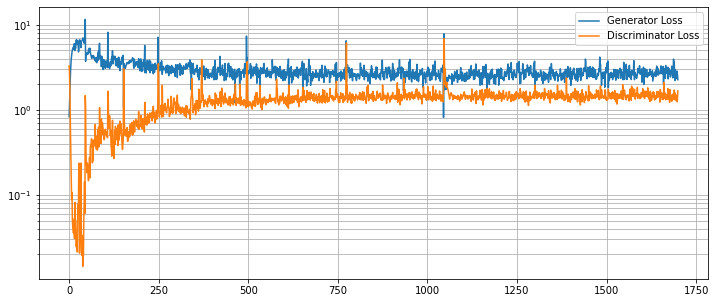

In [17]:
plt.figure(figsize=(12, 5))
plt.semilogy(g_loss, label="Generator Loss")
plt.semilogy(d_loss, label="Discriminator Loss")
plt.grid(True, "both", "both")
plt.legend()
plt.show()

### View image reconstructions
With random latent codes view trained generator output.

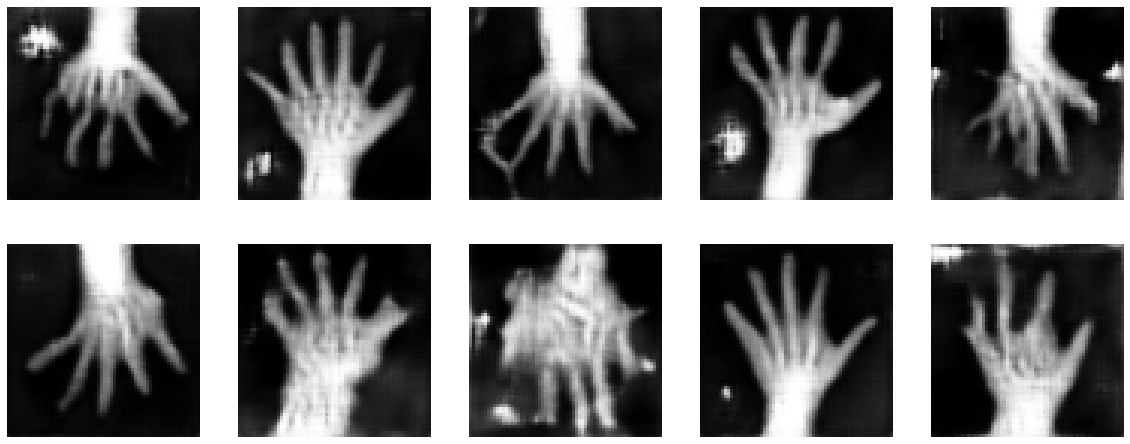

In [18]:
test_img_count = 10
test_latents = default_make_latent(test_img_count, latent_size).to(device)
fakes = gen_net(test_latents)

fig, axs = plt.subplots(2, (test_img_count // 2), figsize=(20, 8))
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.axis("off")
    ax.imshow(fakes[i, 0].cpu().data.numpy(), cmap="gray")

### Cleanup data directory

Remove directory if a temporary was used.

In [20]:
if directory is None:
    shutil.rmtree(root_dir)